In [1]:
from datasets import load_dataset
import pandas as pd
from rank_bm25 import BM25Okapi
import numpy as np
from tqdm import tqdm
LANG_CODE = 'su'
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt')

c4 = load_dataset("allenai/c4", LANG_CODE)
c4_dev_dict = c4.data['validation'].to_pydict()
c4_train_dict = c4.data['train'].to_pydict()

/Users/chaosarium/anaconda3/envs/multi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mabl_df = pd.read_csv(f'../langdata/{LANG_CODE}.csv')
# mabl_su_df = pd.read_csv('../translate-test/su.csv')
# mabl_su_df = pd.read_csv('../data/syntax_chunked/syntax_tagged_su.csv')

In [3]:
mabl_df

,ending1,ending2,startphrase,labels
0,hirup kawas kakekang,hirup kawas bebas.,hirup kawas kurung batok,0
1,hirup kawas kakekang,hirup kawas bebas.,hirup kawas murag bulu bitis.,1
2,jadi jalma teh kudu rajin,jadi jalma teh kudu kedul.,jadi jalma teh kudu hampang birit,0
3,jadi jalma teh kudu rajin,jadi jalma teh kudu kedul.,jadi jalma teh kudu beurat birit.,1
4,mamat lumpat siga gancang,mamat lumpat siga laun.,Mamat lumpatna siga uncal,0
...,...,...,...,...
595,Balik sareng mantan mah seru,Balik sareng mantan mah bosen.,Balik deui sareng mantan sapertos nganggo baju...,1
596,Hubungan jarak jauh pinuh ku rintangan,Hubungan jarak jauh teu aya rintanganana.,Hubungan jarak jauh ibarat arum jeram di sungai,0
597,Hubungan jarak jauh pinuh ku rintangan,Hubungan jarak jauh teu aya rintanganana.,Hubungan jarak jauh ibarat numpakan kano di ta...,1
598,Panghina nyieun leuwih getol,Panghina nyieun nelangsa.,Panghina ti batur mah siga kusir keur mecut kuda,0


In [28]:
start_phrases = mabl_df['startphrase'].tolist()
ending1s = mabl_df['ending1'].tolist()
ending2s = mabl_df['ending2'].tolist()

In [34]:
figqa_examples = list(map(lambda tri: f"{tri[0]} {tri[1]} {tri[2]}".replace(".", "").replace(",", ""), zip(start_phrases, ending1s, ending2s)))

In [35]:
c4_dev_dict['text'][:5]

['Etas luctus - Linda Naor\nEtas luctus2014-08-212014-08-21https://lindanaor.com/wp-content/uploads/2019/01/linda-naor-logo.pngLinda Naorhttps://lindanaor.com/wp-content/uploads/2019/01/linda-naor-logo.png200px200px',
 'Lukas 9 (MANGGARAI)\nMori Yésus Wuat Campulu Suad Rasuln (Mat 10:5-15; Mr 6:7-13)\n1Itu kali Mori Yésus bénta campulu suad rasul, poli hitu téing mberes agu kuasa oné isé, kudut wur jing, agu latang te ina taung sanggéd beti.\n2Agu hia wuat isé kudut keréba Adak de Mori Keraéng, agu pandé ina ata,\n3mai taé Diha ngong isé: “Néka ba apa-apa du ngo lako, néka ba do’ar ko bokong, roti ko doi, ko suan baju.\n4Méu émé poli tiba lata oné ca mbaru, ka’éng nitum dengkir méu angkak nitu mais.\n5Émé manga ata situt toé gorid te tiba méu, pé’ang oné mai béndar disés, agu péntang kebok wa’is, cama ného te langi isé.”\n6Itu kali ngod isé, agu isé lako labok taung béo, cang agu wéro keréba di’ad agu pandé ina ata beti néténg tana.\nHi Hérodés Agu Mori Yésus (Mat 14:1-12; Mr 6:14-29)\

## General

In [36]:
def tokenize(text: str, lang: str):
    # nlp = stanza.Pipeline(lang=lang, processors='tokenize', tokenize_no_ssplit=True)
    return nltk.word_tokenize(text, language=lang, preserve_line=True)

tokenize(figqa_examples[6], LANG_CODE)

['hirup',
 'teh',
 'kudu',
 'boga',
 'pamadeugan',
 'hirup',
 'teh',
 'kudu',
 'boga',
 'pendirian',
 'hirup',
 'teh',
 'kudu',
 'boga',
 'plin-plan']

In [37]:
queries = figqa_examples[:100]
example_pool = c4_train_dict['text'][:70]
tokenized_example_pool = [tokenize(text, LANG_CODE) for text in example_pool]
tokenized_queries = [tokenize(text, LANG_CODE) for text in queries]

## BM25 example selection

In [38]:
def bm25_score_docs(tokenized_queries: list[list[str]], tokenized_example_pool: list[list[str]]):
    scores_acc = np.zeros(len(tokenized_example_pool))
    bm25 = BM25Okapi(tokenized_example_pool)
    for i, tokenized_query in tqdm(enumerate(tokenized_queries)):
        scores_acc += bm25.get_scores(tokenized_query)
    scores_acc /= len(tokenized_example_pool)
    return scores_acc

bm25_score_docs(tokenized_queries, tokenized_example_pool)

100it [00:00, 2779.42it/s]


array([3.72148061e-01, 8.09862813e+00, 0.00000000e+00, 3.96563336e+00,
       1.63575173e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.58250985e-02,
       0.00000000e+00, 0.00000000e+00, 1.46561395e+01, 0.00000000e+00,
       0.00000000e+00, 1.27043616e+01, 0.00000000e+00, 1.38359198e+01,
       3.87642049e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.01438910e+01, 0.00000000e+00, 0.00000000e+00,
       1.37442875e+01, 1.87529446e+00, 0.00000000e+00, 3.21989907e+01,
       9.69102975e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.06898356e-01, 0.00000000e+00, 1.47862807e+01, 1.73997800e-01,
       0.00000000e+00, 0.00000000e+00, 3.09060069e-02, 0.00000000e+00,
       0.00000000e+00, 6.95504257e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.40946194e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.01676939e+01, 0.00000000e+00,
      

## Filtering by similarity metric

In [39]:
class TokenizerForRouge:
    def __init__(self):
        pass
    def tokenize(self, already_tokenized):
        # return tokenize(text, LANG_CODE)
        return already_tokenized

In [40]:
def rouge_score_docs(tokenized_queries: list[list[str]], tokenized_example_pool: list[list[str]]):
    scores_acc = np.zeros(len(tokenized_example_pool))
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False, tokenizer=TokenizerForRouge())
    
    for i, tokenized_query in tqdm(enumerate(tokenized_queries), total=len(tokenized_queries)):
        for j, tokenized_example in enumerate(tokenized_example_pool):              
            rouge_out = scorer.score(tokenized_query, tokenized_example)
            (rouge1, rouge2, rougel) = (rouge_out["rouge1"].fmeasure, rouge_out["rouge2"].fmeasure, rouge_out["rougeL"].fmeasure)
            rouge_overall = sum([rouge1, rouge2, rougel])
            scores_acc[j] += rouge_overall

    scores_acc /= len(tokenized_example_pool)
    return scores_acc

rouge_score_docs(tokenized_queries, tokenized_example_pool)

100%|██████████| 100/100 [00:05<00:00, 16.88it/s]


array([0.00200501, 0.03149363, 0.        , 0.00693644, 0.00517758,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00112045, 0.        , 0.        , 0.02445535,
       0.        , 0.        , 0.02893605, 0.        , 0.03439729,
       0.01261124, 0.        , 0.        , 0.        , 0.        ,
       0.05861656, 0.        , 0.        , 0.07371026, 0.00360774,
       0.        , 0.10515156, 0.00069794, 0.        , 0.        ,
       0.        , 0.00414079, 0.        , 0.01258332, 0.00158245,
       0.        , 0.        , 0.00098522, 0.        , 0.        ,
       0.0030765 , 0.        , 0.        , 0.        , 0.0361455 ,
       0.        , 0.        , 0.        , 0.        , 0.02682313,
       0.        , 0.        , 0.00581044, 0.        , 0.00267857,
       0.02917591, 0.00100691, 0.        , 0.00197044, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

## Filtering and writing results to file

In [53]:
score_arr = bm25_score_docs(tokenized_queries, tokenized_example_pool)
sorted_scored_examples = []
for score, example in zip(score_arr, example_pool):
    sorted_scored_examples.append({'score': score, 'example': example})
sorted_scored_examples.sort(key=lambda x: -x['score'])

100it [00:00, 2572.21it/s]


In [60]:
from datasets import Dataset
DSETSIZE = 50000
scores_list = list(map(lambda x: x['score'], sorted_scored_examples[:DSETSIZE]))
example_list = list(map(lambda x: x['example'], sorted_scored_examples[:DSETSIZE]))
curated_hf_dataset = Dataset.from_dict({'score': scores_list, 'example': example_list})

In [61]:
curated_hf_dataset.save_to_disk(f'select_datasets/{LANG_CODE}/rouge{DSETSIZE}')

Saving the dataset (1/1 shards): 100%|██████████| 70/70 [00:00<00:00, 15161.44 examples/s]


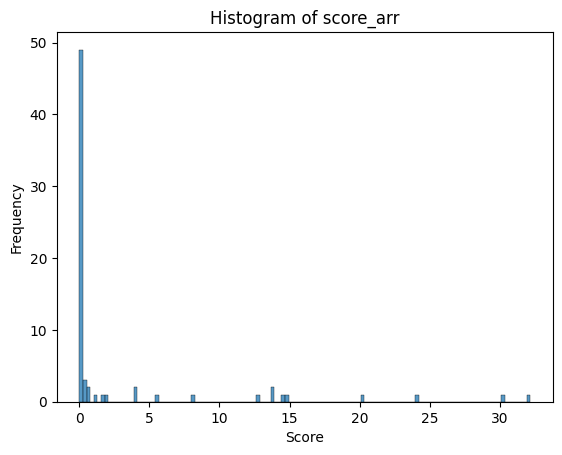

<Figure size 640x480 with 0 Axes>

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram using seaborn
sns.histplot(scores_list)

# Set plot title and labels
plt.title("Histogram of score_arr")
plt.xlabel("Score")
plt.ylabel("Frequency")

# Show the plot
plt.show()

# Save the plot to disk
plt.savefig(f'select_datasets/{LANG_CODE}/rouge{DSETSIZE}/score_dist.png')


---
# graveyard

In [ ]:
def ngram_overlap_score(source: str, example: list[str]) -> float:
    from nltk.translate.bleu_score import (SmoothingFunction, sentence_bleu,)

    hypotheses = source.split()
    references = [s.split() for s in example]

    return float(
        sentence_bleu(
            references,
            hypotheses,
            smoothing_function=SmoothingFunction().method1,
            auto_reweigh=True,
        )
    )
 
def select_examples(queries: list[str], example_pool: list[str], threshold = -1.0) -> list[dict]:
    selected_examples = []
    queries_size = len(queries)
    pool_size = len(example_pool)
    print(f"selecting from example pool of size {pool_size}")
    print(f"matching against {queries_size} queries")
    scores = [0.0] * pool_size

    for i in tqdm(range(queries_size)):
        for j in range(pool_size):
            scores[j] += ngram_overlap_score(
                queries[i], [example_pool[j]]
            )

    score_scratch = [s for s in scores]
    while True:
        arg_max = np.argmax(score_scratch)
        if (score_scratch[arg_max] < threshold) or (score_scratch[arg_max] == 0):
            break

        selected_examples.append((score_scratch[arg_max], example_pool[arg_max]))
        score_scratch[arg_max] = threshold - 1.0

    return scores, selected_examples

scores, selected_examples = select_examples(
    queries = queries,
    example_pool = example_pool,
    threshold=0
)

for e in selected_examples:
    print(e)